# CISC489 Final Project:
**<h3>Modeling Traffic Flow with Physics-Informed Neural Networks (PINNs) Using the LWR Equation<h3>**

## Imports and problem setup

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# traffic fundamental diagram: v(ρ) = 1 - ρ (dimensionless)
def flux(rho):
    return rho * (1 - rho)

# domain boundaries
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

# number of training points
N_f = 20_000   # collocation (interior) points
N_b = 200      # boundary points
N_i = 200      # initial points


## Define the PINN model

In [17]:
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-2):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.layers.append(nn.Linear(layers[-2], layers[-1]))

        # initialize weights
        for m in self.layers:
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        for layer in self.layers[:-1]:
            X = self.activation(layer(X))
        return self.layers[-1](X)


## PDE residual and loss functions


In [18]:
def pde_residual(model, x, t):
    # predict density
    rho = model(x, t)
    # gradients
    rho_t = torch.autograd.grad(rho, t, grad_outputs=torch.ones_like(rho),
                                retain_graph=True, create_graph=True)[0]
    rho_x = torch.autograd.grad(rho, x, grad_outputs=torch.ones_like(rho),
                                retain_graph=True, create_graph=True)[0]
    # flux derivative
    f = flux(rho)
    f_x = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f),
                              retain_graph=True, create_graph=True)[0]
    # PDE: rho_t + f_x = 0
    return rho_t + f_x


## Generate training data

In [19]:
# interior collocation points
x_f = torch.rand(N_f,1)*(x_max-x_min) + x_min
t_f = torch.rand(N_f,1)*(t_max-t_min) + t_min

# initial condition: a Gaussian pulse
x_i = torch.linspace(x_min, x_max, N_i).view(-1,1)
t_i = torch.zeros_like(x_i)
rho_i = torch.exp(-100*(x_i-0.5)**2)  # pulse centered at 0.5

# left/right boundary: zero-gradient (Neumann)
t_b = torch.linspace(t_min, t_max, N_b).view(-1,1)
x_b0 = torch.full_like(t_b, x_min)
x_b1 = torch.full_like(t_b, x_max)


## Move data to device and set requires_grad


In [20]:
x_f = x_f.to(device).requires_grad_(True)
t_f = t_f.to(device).requires_grad_(True)

x_i, t_i, rho_i = x_i.to(device), t_i.to(device), rho_i.to(device)

# For boundary points, enable gradient tracking on x so we can do ∂ρ/∂x
x_b0 = x_b0.to(device).requires_grad_(True)
x_b1 = x_b1.to(device).requires_grad_(True)
t_b  = t_b.to(device)  # we only need grad w.r.t. x, t_b can remain False


## Instantiate model and optimizer


In [21]:
layers = [2, 50, 50, 50, 1]
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Training loop

In [22]:
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # PDE loss
    r = pde_residual(model, x_f, t_f)
    loss_pde = torch.mean(r**2)

    # IC loss
    rho_pred_i = model(x_i, t_i)
    loss_ic = torch.mean((rho_pred_i - rho_i)**2)

    # BC loss: enforce zero derivative at x=0 and x=1
    rho_b0 = model(x_b0, t_b)
    rho_b1 = model(x_b1, t_b)
    rho_x_b0 = torch.autograd.grad(rho_b0, x_b0,
                                   grad_outputs=torch.ones_like(rho_b0),
                                   retain_graph=True, create_graph=True)[0]
    rho_x_b1 = torch.autograd.grad(rho_b1, x_b1,
                                   grad_outputs=torch.ones_like(rho_b1),
                                   retain_graph=True, create_graph=True)[0]

    loss_bc = torch.mean(rho_x_b0**2) + torch.mean(rho_x_b1**2)

    # total loss
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.3e} (PDE {loss_pde.item():.1e}, IC {loss_ic.item():.1e}, BC {loss_bc.item():.1e})")


Epoch 0/5000 — Loss: 2.073e-01 (PDE 4.5e-02, IC 1.1e-01, BC 5.4e-02)
Epoch 500/5000 — Loss: 9.300e-02 (PDE 7.9e-06, IC 9.2e-02, BC 5.7e-04)
Epoch 1000/5000 — Loss: 5.156e-02 (PDE 1.4e-02, IC 3.7e-02, BC 1.8e-04)
Epoch 1500/5000 — Loss: 5.064e-02 (PDE 1.4e-02, IC 3.7e-02, BC 1.8e-04)
Epoch 2000/5000 — Loss: 5.051e-02 (PDE 1.4e-02, IC 3.7e-02, BC 1.4e-04)
Epoch 2500/5000 — Loss: 5.041e-02 (PDE 1.4e-02, IC 3.6e-02, BC 1.4e-04)
Epoch 3000/5000 — Loss: 5.020e-02 (PDE 1.4e-02, IC 3.6e-02, BC 1.5e-04)
Epoch 3500/5000 — Loss: 4.957e-02 (PDE 1.4e-02, IC 3.6e-02, BC 1.9e-04)
Epoch 4000/5000 — Loss: 4.537e-02 (PDE 1.3e-02, IC 3.2e-02, BC 9.2e-05)
Epoch 4500/5000 — Loss: 4.369e-02 (PDE 1.3e-02, IC 3.1e-02, BC 8.8e-05)


## Visualize results at a few time slices


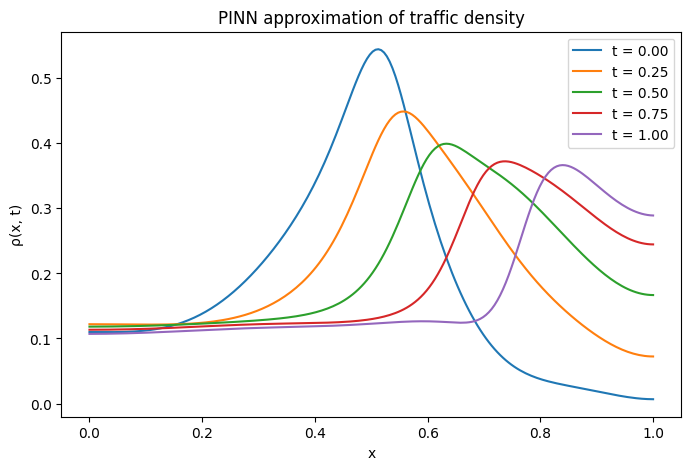

In [23]:
model.eval()
x_plot = torch.linspace(x_min, x_max, 200).view(-1,1).to(device)
plt.figure(figsize=(8,5))
for t_val in [0.0, 0.25, 0.5, 0.75, 1.0]:
    t_plot = torch.full_like(x_plot, t_val)
    rho_plot = model(x_plot, t_plot).detach().cpu().numpy()
    plt.plot(x_plot.cpu(), rho_plot, label=f"t = {t_val:.2f}")
plt.xlabel("x")
plt.ylabel("ρ(x, t)")
plt.title("PINN approximation of traffic density")
plt.legend()
plt.show()


## Saving Results for Use in Visualization

In [30]:
import numpy as np
import pandas as pd
import json

# dump JSON for React
out = {
    "x": x_vals.numpy().flatten().tolist(),
    "t": t_vals.numpy().flatten().tolist(),
    "rho": rho.tolist()
}
with open("density.json","w") as f:
    json.dump(out, f)
